In [27]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from collections import defaultdict

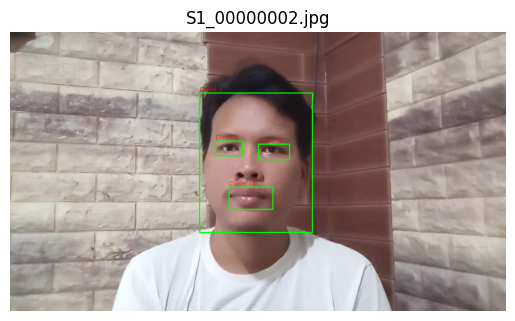

In [28]:
import os
import cv2
import matplotlib.pyplot as plt

base_path = "Cheat Database"

for scenario in sorted(os.listdir(base_path)):
    scenario_path = os.path.join(base_path, scenario)
    if not os.path.isdir(scenario_path):
        continue

    for filename in os.listdir(scenario_path):
        if not filename.endswith(".jpg"):
            continue

        img_path = os.path.join(scenario_path, filename)
        txt_path = img_path.replace(".jpg", ".txt")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w = img.shape[:2]

        if os.path.exists(txt_path):
            with open(txt_path, "r") as f:
                for line in f:
                    class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
                    x1 = int((x_center - box_w / 2) * w)
                    y1 = int((y_center - box_h / 2) * h)
                    x2 = int((x_center + box_w / 2) * w)
                    y2 = int((y_center + box_h / 2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, f"Class {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
        plt.show()

        break  # remove this to view all images
    break  # remove this to go through all scenarios


In [32]:
import os
import pandas as pd

train_test = 'Cheat Database/'  # relative path from your notebook
row, col = 48, 48
classes = 2

def count_exp(path, set_):
    count_dict = {}

    for label_folder in sorted(os.listdir(path)):
        label_path = os.path.join(path, label_folder)

        if not os.path.isdir(label_path):
            continue

        count = len([f for f in os.listdir(label_path) if f.endswith('.jpg')])
        count_dict[label_folder] = count

    df = pd.DataFrame(count_dict, index=[set_])
    return df

train_test_data = count_exp(train_test, 'train')
print(train_test_data)

# Optional: transpose for prettier output
train_test_data.transpose()


       Scenario 1  Scenario 10  Scenario 11  Scenario 12  Scenario 13  \
train        1188          172          183          116          237   

       Scenario 14  Scenario 15  Scenario 16  Scenario 17  Scenario 18  ...  \
train          543           53          110          134          211  ...   

       Scenario 55  Scenario 56  Scenario 57  Scenario 58  Scenario 59  \
train           56          159          184           43          668   

       Scenario 6  Scenario 60  Scenario 7  Scenario 8  Scenario 9  
train         287          341         486         203          48  

[1 rows x 60 columns]


,train
Scenario 1,1188
Scenario 10,172
Scenario 11,183
Scenario 12,116
Scenario 13,237
Scenario 14,543
Scenario 15,53
Scenario 16,110
Scenario 17,134
Scenario 18,211


In [34]:
train_test = 'Cheat Database/'

row, col = 48, 48
classes = 2

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_test_data = count_exp(train_test,'train' )

print(train_test_data)

       Scenario 1  Scenario 10  Scenario 11  Scenario 12  Scenario 13  \
train        2376          344          366          232          474   

       Scenario 14  Scenario 15  Scenario 16  Scenario 17  Scenario 18  ...  \
train         1086          106          220          268          422  ...   

       Scenario 55  Scenario 56  Scenario 57  Scenario 58  Scenario 59  \
train          112          318          368           86         1336   

       Scenario 6  Scenario 60  Scenario 7  Scenario 8  Scenario 9  
train         574          682         972         406          96  

[1 rows x 60 columns]


In [37]:
datapath = 'train/'
# Create the training and testing directories
train_dir = os.path.join(datapath, 'train')
test_dir = os.path.join(datapath, 'test')

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255        # fill any gaps created by image transformations with the nearest pixel value
)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=16,
                                                target_size=(48,48),
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=16,
                                                target_size=(48,48),
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
